In [1]:
#!pip3 install --user torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    


Looking in indexes: https://download.pytorch.org/whl/cu118


In [1]:
import torch

# Check if CUDA is available
cuda_available = torch.cuda.is_available()

if cuda_available:
    print("CUDA is available.")
    # Print CUDA device count and name
    device_count = torch.cuda.device_count()
    print(f"Number of CUDA devices: {device_count}")
    for i in range(device_count):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available.")


CUDA is available.
Number of CUDA devices: 1
Device 0: NVIDIA GeForce RTX 3060 Laptop GPU


In [2]:
torch.cuda.is_available()

True

In [3]:
from torchvision import models, transforms
from sess import SESS
from cam import GradCAM, CAM, GuidedBackProp, GroupCAM, ScoreCAM # import base visualiation methods
from utils import load_image, save_img_with_heatmap, check_path_exist, apply_transforms, save_heatmap
import time
import json
from utils import get_transform
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def get_ImageNet_classes():
    """
        Load imagenet labels.
    """
    LABELS_file = 'utils/resources/imagenet_class_index.json'
    with open(LABELS_file, 'r') as f:
        class_ids =json.load(f)
    return class_ids

def saliency_visualisation(img, saliency):
    fig, ax = plt.subplots(1,2)
    img_heatmap = save_img_with_heatmap(img, saliency, None, style='zhou', normalise=True)
    # plt.imshow((img_heatmap[:, :, ::-1]).astype(np.uint8))
    ax[0].imshow((img_heatmap[:, :, ::-1]).astype(np.uint8))
    heatmap = save_heatmap(saliency, None, normalise=True)
    ax[1].imshow((heatmap[:, :, ::-1]).astype(np.uint8))

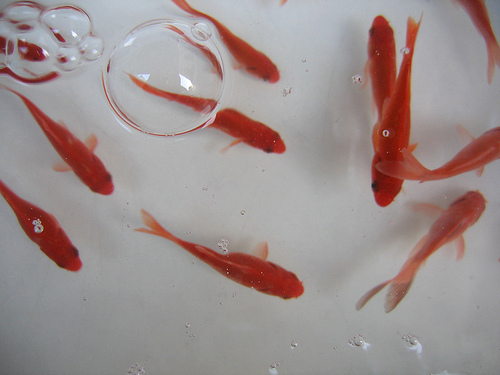

In [5]:
# Load target iamge
image_file = 'examples/goldfish.jpg' # More examples exist in the examples folder
img = load_image(image_file)
display(img)

In [14]:
# Model and base visualisation method initialisation
model = 'resnet50'
target_layer = 'layer4'
model = models.__dict__[model](pretrained=True).eval()
model = model.cuda()

In [15]:
target_class_id = None # When target class id is None, target class is the most activated class
class_ids = get_ImageNet_classes()
if target_class_id is not None:
    print('Current class label is', class_ids[str(target_class_id)][1])

# Grad-cam Vs Grad-cam with SESS

In [16]:
# Gradcam
gc = GradCAM(model, target_layer=target_layer)

In [17]:
transform = get_transform(resize_size=224, center_crop_size=None)
x = transform(img).unsqueeze(0)
start = time.time()
saliency, _ = gc(x, target_class_id)
print('Total time: {:.2f} second'.format((time.time()-start)))
saliency = cv2.resize(np.squeeze(saliency), img.size)
#print('Current class is ', class_ids[str(idx)][1])

Total time: 0.17 second


Saliency generated by Grad-CAM


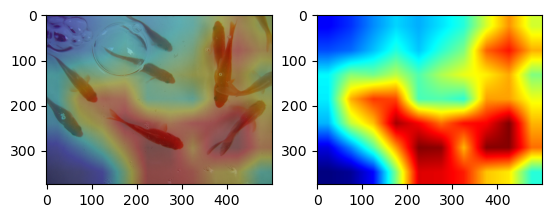

In [23]:
print('Saliency generated by Grad-CAM')
saliency_visualisation(img, saliency)

In [24]:
# Set SESS parameters
num_scales = 12
scales = [224 + 64 * i for i in range(num_scales)]
pre_filter_ratio = 0
theta = 0
step_size = 224
sess = SESS(gc, pre_filter_ratio=pre_filter_ratio, theta=theta, pool='mean',
            window_size=224, step_size=step_size, min_overlap_ratio=1, scales=scales,
            requires_grad=False, output=None, verbose=1, smooth=True)

In [25]:
transform = get_transform(resize_size=None, center_crop_size=None)
x = transform(img).unsqueeze(0)
start = time.time()
saliency, idx = sess(x, target_class_id)
print('Total time: {:.2f} second'.format((time.time()-start)))
saliency = cv2.resize(saliency, img.size)
print('Current class is ', class_ids[str(idx)][1])

C:\Users\Swajay\Downloads\project\env\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


The target class id is  1
Total number of all extracted patches:  157
Total number of remained patches: 157
Total number of channels:  157
Total time: 14.45 second
Current class is  goldfish


Saliency generated by Grad-CAM with SESS


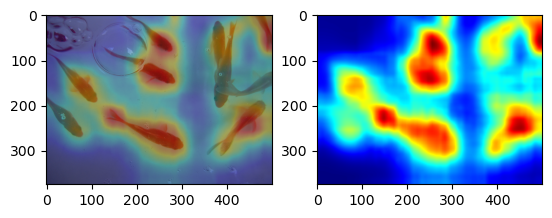

In [26]:
print('Saliency generated by Grad-CAM with SESS')
saliency_visualisation(img, saliency)

# GuidedBP vs GuidedBP with SESS

In [27]:
gp = GuidedBackProp(model)
transform = get_transform(resize_size=(224, 224), center_crop_size=None)
x = transform(img).unsqueeze(0)
x = transform(img).unsqueeze(0)
start = time.time()
saliency, _ = gp(x, target_class_id)
print('Total time: {:.2f} second'.format((time.time()-start)))

Total time: 1.15 second


Saliency generated by Guided Backpropagation


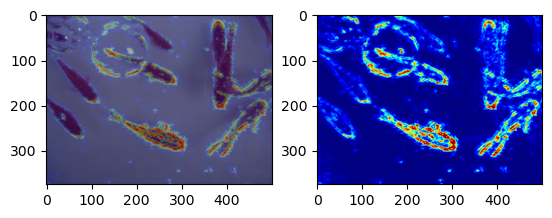

In [28]:
saliency = cv2.resize(np.squeeze(saliency), img.size)
print('Saliency generated by Guided Backpropagation')
saliency_visualisation(img, saliency)

In [29]:
# Set SESS parameters
num_scales = 12
scales = [224 + 64 * i for i in range(num_scales)]
pre_filter_ratio = 0
theta = 0
step_size = 224
sess = SESS(gp, pre_filter_ratio=pre_filter_ratio, theta=theta, pool='mean',
            window_size=224, step_size=step_size, min_overlap_ratio=1, scales=scales,
            requires_grad=False, output=None, verbose=1, smooth=True)

In [30]:
transform = get_transform(resize_size=None, center_crop_size=None)
x = transform(img).unsqueeze(0)
start = time.time()
saliency, idx = sess(x, target_class_id)
print('Total time: {:.2f} second'.format((time.time()-start)))
saliency = cv2.resize(saliency, img.size)
print('Current class is ', class_ids[str(idx)][1])

The target class id is  1
Total number of all extracted patches:  157
Total number of remained patches: 157
Total number of channels:  157
Total time: 13.34 second
Current class is  goldfish


Saliency generated by Guided Backpropagation with SESS


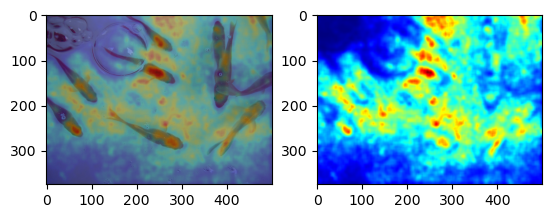

In [31]:
print('Saliency generated by Guided Backpropagation with SESS')
saliency_visualisation(img, saliency)

# Group-CAM vs Group-CAM with SESS

In [32]:
grc = GroupCAM(model, target_layer=target_layer)
transform = get_transform(resize_size=(224, 224), center_crop_size=None)
x = transform(img).unsqueeze(0)
x.requires_grad = True
start = time.time()
saliency, _ = grc(x.cuda(), target_class_id)
print('Total time: {:.2f} second'.format((time.time()-start)))

Total time: 1.36 second


Saliency generated by GroupCAM


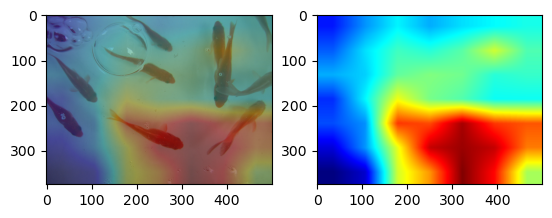

In [33]:
print('Saliency generated by GroupCAM')
saliency = np.squeeze(saliency)
saliency = cv2.resize(saliency, img.size)
saliency_visualisation(img, saliency)

In [34]:
# Set SESS parameters
num_scales = 12
scales = [224 + 64 * i for i in range(num_scales)]
pre_filter_ratio = 0
theta = 0
step_size = 224
sess = SESS(grc, pre_filter_ratio=pre_filter_ratio, theta=theta, pool='mean',
            window_size=224, step_size=step_size, min_overlap_ratio=1, scales=scales,
            requires_grad=False, output=None, verbose=1, smooth=True)

In [35]:
transform = get_transform(resize_size=None, center_crop_size=None)
x = transform(img).unsqueeze(0)
start = time.time()
saliency, idx = sess(x, target_class_id)
print('Total time: {:.2f} second'.format((time.time()-start)))
saliency = cv2.resize(saliency, img.size)
print('Current class is ', class_ids[str(idx)][1])

The target class id is  1
Total number of all extracted patches:  157
Total number of remained patches: 157
Total number of channels:  157
Total time: 22.85 second
Current class is  goldfish


Saliency generated by Group-CAM with SESS


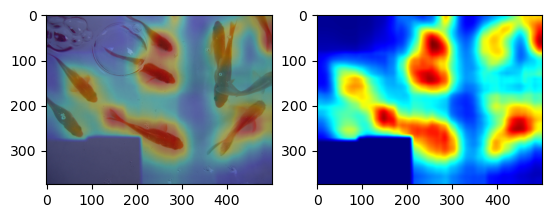

In [36]:
print('Saliency generated by Group-CAM with SESS')
saliency_visualisation(img, saliency)

In [37]:
# Score-CAM vs Group-CAM with SESS

In [38]:
sc = ScoreCAM(model, target_layer=target_layer)

In [39]:
transform = get_transform(resize_size=(224, 224), center_crop_size=None)
x = transform(img).unsqueeze(0)
start = time.time()
saliency, _ = sc(x.cuda(), target_class_id)
print('Total time: {:.2f} second'.format((time.time()-start)))

Total time: 27.09 second


Saliency generated by Score-CAM


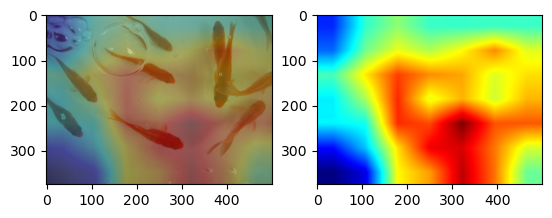

In [40]:
print('Saliency generated by Score-CAM')
saliency = np.squeeze(saliency)
saliency = cv2.resize(saliency, img.size)
saliency_visualisation(img, saliency)

In [41]:
# Set SESS parameters
# To efficiency, few sacles and high pre_filter_ration are applied
num_scales = 5
scales = [224 + 64 * i for i in range(num_scales)]
pre_filter_ratio = 0.5
theta = 0
step_size = 224
sess = SESS(sc, pre_filter_ratio=pre_filter_ratio, theta=theta, pool='mean',
            window_size=224, step_size=step_size, min_overlap_ratio=1, scales=scales,
            requires_grad=False, output=None, verbose=1, smooth=True)

In [42]:
transform = get_transform(resize_size=224, center_crop_size=None)
x = transform(img).unsqueeze(0)
start = time.time()
saliency, idx = sess(x, target_class_id)
print('Total time: {:.2f} second'.format((time.time()-start)))
saliency = cv2.resize(saliency, img.size)
print('Current class is ', class_ids[str(idx)][1])

The target class id is  1
Total number of all extracted patches:  27
Total number of remained patches: 14
Total number of channels:  14
Total time: 375.75 second
Current class is  goldfish


Saliency generated by Score-CAM with SESS


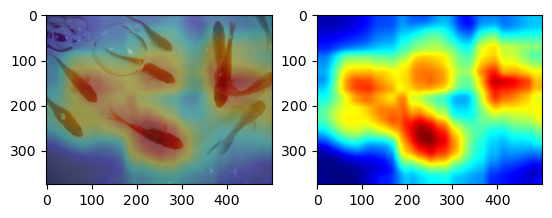

In [43]:
print('Saliency generated by Score-CAM with SESS')
saliency = np.squeeze(saliency)
saliency = cv2.resize(saliency, img.size)
saliency_visualisation(img, saliency)